In [1]:
import os
import numpy as np
import time 
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import math

from PIL import Image

import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import patches as mpatches
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Set seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train Validation Split

In [2]:
data_path = '/kaggle/input/medical-aug2024'  # trained on kaggle
data_path = 'Medical_Aug2024/'

image_dir = f'{data_path}/train_images/'
mask_dir = f'{data_path}/train_masks/'

all_filenames = sorted(os.listdir(image_dir))

In [3]:
total_images = len(all_filenames)

train_size = int(0.90 * total_images)
val_size = int(0.10 * total_images)

train_filenames, val_filenames = train_test_split(all_filenames,test_size=(val_size),random_state=42)

print(f"Total images: {len(all_filenames)}")
print(f"Training images: {len(train_filenames)}")
print(f"Validation images: {len(val_filenames)}")
# print(f"Test images: {len(test_filenames)}")

Total images: 1631
Training images: 1468
Validation images: 163


# Dataset

In [4]:
import os
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class ImageMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, filenames, transform_image=None, transform_mask=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = os.listdir(image_dir)
        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        image_path = os.path.join(self.image_dir, img_name)
        mask_name = img_name  # Since filenames match
        mask_path = os.path.join(self.mask_dir, mask_name)

        # load images
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # 'L' mode for grayscale

        # transform
        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask


In [ ]:
from torchvision import transforms

transform_image = transforms.Compose([
   transforms.Resize((224, 224)),
   transforms.ToTensor(),
   transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_mask = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.NEAREST),
    transforms.PILToTensor(),
    transforms.Lambda(lambda x: x.squeeze().long())
])


# Data Loaders

In [ ]:
# train
train_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=train_filenames,
    transform_image=transform_image,
    transform_mask=transform_mask
)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)

# validation
val_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=val_filenames,
    transform_image=transform_image,
    transform_mask=transform_mask
)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

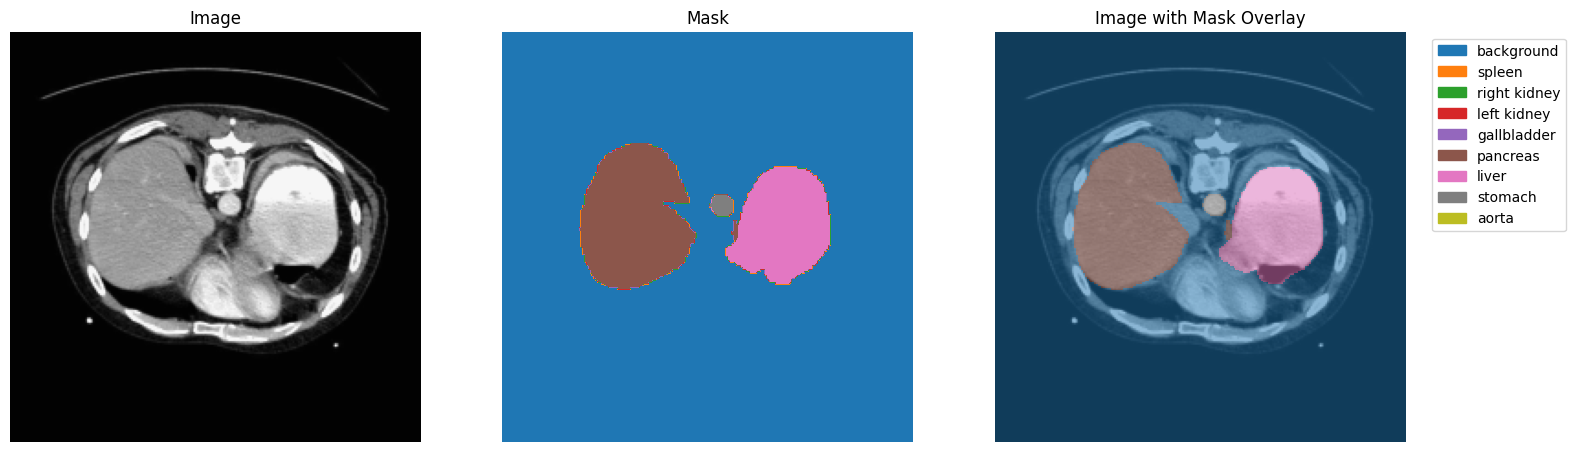

In [9]:
def visualize_sample(dataset, idx=None, filename=None):

    if idx is not None:
        image, mask = dataset[idx]
        img_name = dataset.image_filenames[idx]
    elif filename is not None:
        idx = dataset.image_filenames.index(filename)
        image, mask = dataset[idx]
        img_name = filename
    else:
        raise ValueError("Either idx or filename must be provided.")


    image_np = image.permute(1, 2, 0).numpy()
    image_np = image_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    image_np = np.clip(image_np, 0, 1)

    mask_np = mask.numpy()

    # define class names and colors
    class_names = ['background', 'spleen', 'right kidney', 'left kidney', 'gallbladder', 'pancreas', 'liver', 'stomach', 'aorta']
    colors = plt.cm.tab10.colors
    colormap = mcolors.ListedColormap(colors[:9])

    mask_rgba = colormap(mask_np / 8.0)
    mask_rgba[..., 3] = 0.5  # Set alpha for transparency

    # plot image and mask
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    ax1.imshow(image_np)
    ax1.set_title('Image')
    ax1.axis('off')

    ax2.imshow(mask_np, cmap=colormap, vmin=0, vmax=8)
    ax2.set_title('Mask')
    ax2.axis('off')

    ax3.imshow(image_np)
    ax3.imshow(mask_rgba, interpolation='none')
    ax3.set_title('Image with Mask Overlay')
    ax3.axis('off')

    # Create legend
    patches = [mpatches.Patch(color=colors[i], label=class_names[i]) for i in range(len(class_names))]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

visualize_sample(train_dataset, idx=1)


# Model

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout)
        )

    def forward(self, x):
        return self.conv(x)

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mode='transpose'):
        super(UpBlock, self).__init__()
        if mode == 'transpose':
            self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        elif mode == 'bilinear':
            self.up = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(in_channels, out_channels, kernel_size=1)
            )
        else:
            raise ValueError("Invalid mode for upsampling. Choose 'transpose' or 'bilinear'.")

    def forward(self, x):
        return self.up(x)
    

class UNetPlusPlus50(nn.Module):
    def __init__(self, in_channels=3, out_channels=9, dropout=0.5):
        super(UNetPlusPlus50, self).__init__()

        # load pretrained ResNet50
        resnet = models.resnet50(pretrained=True)

        # take layers from ResNet50 to use as encoders
        self.encoder = nn.ModuleList([
            resnet.conv1,   # [64, H/2, W/2]
            resnet.bn1,
            resnet.relu,
            resnet.maxpool, # [64, H/4, W/4]
            resnet.layer1,  # [256, H/4, W/4]
            resnet.layer2,  # [512, H/8, W/8]
            resnet.layer3,  # [1024, H/16, W/16]
            resnet.layer4   # [2048, H/32, W/32]
        ])

        nb_filter = [64, 256, 512, 1024, 2048]

        # decoder blocks
        self.up3_1 = UpBlock(nb_filter[4], nb_filter[3])  # 2048 -> 1024
        self.conv3_1 = ConvBlock(nb_filter[4], nb_filter[3], dropout=dropout)  # 2048 -> 1024

        self.up2_2 = UpBlock(nb_filter[3], nb_filter[2])  # 1024 -> 512
        self.conv2_2 = ConvBlock(nb_filter[3], nb_filter[2], dropout=dropout)  # 1024

        self.up1_3 = UpBlock(nb_filter[2], nb_filter[1])  # 512 -> 256
        self.conv1_3 = ConvBlock(nb_filter[2], nb_filter[1], dropout=dropout)  # 768

        self.up0_4 = UpBlock(nb_filter[1], nb_filter[0])  # 256 -> 64
        self.conv0_4 = ConvBlock(nb_filter[0] + nb_filter[0], nb_filter[0], dropout=dropout)  # 320

        # extra upsampling back to input size
        self.up_extra = UpBlock(nb_filter[0], nb_filter[0])  # 64 -> 64
        self.conv_extra = ConvBlock(nb_filter[0] + in_channels, nb_filter[0], dropout=dropout)  # 67

        # final output
        self.final = nn.Conv2d(nb_filter[0], out_channels, kernel_size=1)

    def forward(self, x):
        # encoder
        x0 = self.encoder[0](x)    # conv1
        x0 = self.encoder[1](x0)   # bn1
        x0 = self.encoder[2](x0)   # relu
        x0p = self.encoder[3](x0)  # maxpool

        x1 = self.encoder[4](x0p)  # layer1
        x2 = self.encoder[5](x1)   # layer2
        x3 = self.encoder[6](x2)   # layer3
        x4 = self.encoder[7](x3)   # layer4


        # decoder
        x3_1 = self.up3_1(x4)
        x3_1 = torch.cat([x3_1, x3], dim=1)
        x3_1 = self.conv3_1(x3_1)

        x2_2 = self.up2_2(x3_1)
        x2_2 = torch.cat([x2_2, x2], dim=1)  # 1024 channels
        x2_2 = self.conv2_2(x2_2)

        x1_3 = self.up1_3(x2_2)
        x1_3 = torch.cat([x1_3, x1], dim=1)  # 768 channels
        x1_3 = self.conv1_3(x1_3)

        x0_4 = self.up0_4(x1_3)
        x0_4 = torch.cat([x0_4, x0], dim=1)  # 320 channels
        x0_4 = self.conv0_4(x0_4)

        # extra upsampling for prediction
        x_extra = self.up_extra(x0_4)
        x_extra = torch.cat([x_extra, x], dim=1)  # 67 channels
        x_extra = self.conv_extra(x_extra)

        output = self.final(x_extra)
        return output

# Loss Function

In [8]:
# from pytorch toolbelt at https://github.com/BloodAxe/pytorch-toolbelt/tree/develop/pytorch_toolbelt/losses
import typing
from typing import List
from typing import Optional
from torch import Tensor
from torch.nn.modules.loss import _Loss


def to_tensor(x, dtype=None) -> torch.Tensor:
    if isinstance(x, torch.Tensor):
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, np.ndarray) and x.dtype.kind not in {"O", "M", "U", "S"}:
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, (list, tuple)):
        x = np.ndarray(x)
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x

    raise ValueError("Unsupported input type" + str(type(x)))


def soft_dice_score(
    output: torch.Tensor, target: torch.Tensor, smooth: float = 0.0, eps: float = 1e-7, dims=None
) -> torch.Tensor:

    assert output.size() == target.size()
    if dims is not None:
        intersection = torch.sum(output * target, dim=dims)
        cardinality = torch.sum(output + target, dim=dims)
    else:
        intersection = torch.sum(output * target)
        cardinality = torch.sum(output + target)
    dice_score = (2.0 * intersection + smooth) / (cardinality + smooth).clamp_min(eps)
    return dice_score


__all__ = ["DiceLoss"]

BINARY_MODE = "binary"
MULTICLASS_MODE = "multiclass"
MULTILABEL_MODE = "multilabel"


class DiceLoss(_Loss):

    def __init__(
        self,
        mode: str,
        classes: List[int] = None,
        log_loss=False,
        from_logits=True,
        smooth: float = 0.0,
        ignore_index=None,
        eps=1e-7,
    ):

        assert mode in {BINARY_MODE, MULTILABEL_MODE, MULTICLASS_MODE}
        super(DiceLoss, self).__init__()
        self.mode = mode
        if classes is not None:
            assert mode != BINARY_MODE, "Masking classes is not supported with mode=binary"
            classes = to_tensor(classes, dtype=torch.long)

        self.classes = classes
        self.from_logits = from_logits
        self.smooth = smooth
        self.eps = eps
        self.ignore_index = ignore_index
        self.log_loss = log_loss

    def forward(self, y_pred: Tensor, y_true: Tensor) -> Tensor:
        """
        :param y_pred: NxCxHxW
        :param y_true: NxHxW
        :return: scalar
        """
        assert y_true.size(0) == y_pred.size(0)

        if self.from_logits:
            # Apply activations to get [0..1] class probabilities
            # Using Log-Exp as this gives more numerically stable result and does not cause vanishing gradient on
            # extreme values 0 and 1
            if self.mode == MULTICLASS_MODE:
                y_pred = y_pred.log_softmax(dim=1).exp()
            else:
                y_pred = F.logsigmoid(y_pred).exp()

        bs = y_true.size(0)
        num_classes = y_pred.size(1)
        dims = (0, 2)

        if self.mode == BINARY_MODE:
            y_true = y_true.view(bs, 1, -1)
            y_pred = y_pred.view(bs, 1, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        if self.mode == MULTICLASS_MODE:
            y_true = y_true.view(bs, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask.unsqueeze(1)

                y_true = F.one_hot((y_true * mask).to(torch.long), num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1) * mask.unsqueeze(1)  # H, C, H*W
            else:
                y_true = F.one_hot(y_true, num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1)  # H, C, H*W

        if self.mode == MULTILABEL_MODE:
            y_true = y_true.view(bs, num_classes, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        scores = soft_dice_score(y_pred, y_true.type_as(y_pred), smooth=self.smooth, eps=self.eps, dims=dims)

        if self.log_loss:
            loss = -torch.log(scores.clamp_min(self.eps))
        else:
            loss = 1.0 - scores

        # Dice loss is undefined for non-empty classes
        # So we zero contribution of channel that does not have true pixels

        mask = y_true.sum(dims) > 0
        loss *= mask.to(loss.dtype)

        if self.classes is not None:
            loss = loss[self.classes]

        return loss.mean()

In [9]:
class weighted_loss(nn.Module):
    def __init__(self, reduction='mean', lamb=1.25):
        super().__init__()
        self.reduction = reduction
        self.lamb = lamb
        self.base_loss = torch.nn.CrossEntropyLoss(reduction=reduction)
        self.dice_loss = DiceLoss(mode='multiclass')
        
    def forward(self, logits, target):
        base_l = self.base_loss(logits, target)
        dice_l = self.dice_loss(logits, target)
        
        return base_l + self.lamb * dice_l

In [10]:
def compute_iou(preds, labels, num_classes):
    preds = preds.view(-1)
    labels = labels.view(-1)
    intersection = np.zeros(num_classes)
    union = np.zeros(num_classes)

    for cls in range(num_classes):
        pred_inds = (preds == cls)
        label_inds = (labels == cls)
        intersection[cls] = (pred_inds & label_inds).sum().item()
        union[cls] = (pred_inds | label_inds).sum().item()

    return intersection, union

def compute_miou(intersection, union):
    iou_per_class = intersection / (union + 1e-6)  # smoothing to avoid division by zero
    miou = np.nanmean(iou_per_class)
    return miou, iou_per_class

# Train function

In [15]:
def train_model(model, criterion, optimizer, num_epochs=10, patience=5):

    # conv_layer = model.encoder[0]  # This is resnet.conv1
    # before_mean = conv_layer.weight.data.mean().item()
    # print(f"Before Training Mean: {before_mean:.6f}")
    
    best_miou = 0.0
    patience_counter = 0
    num_classes = 9  # Number of classes
    class_names = ['background', 'spleen', 'right kidney', 'left kidney', 'gallbladder',
                   'pancreas', 'liver', 'stomach', 'aorta']

    for epoch in range(num_epochs):
        # training phase
        model.train()
        running_loss = 0.0
        intersection = np.zeros(num_classes)
        union = np.zeros(num_classes)
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            # forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # backward
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            
            # predictions
            _, preds = torch.max(outputs, 1)
            
            # compute intersection and union for each class
            for cls in range(num_classes):
                pred_inds = (preds == cls)
                label_inds = (labels == cls)
                intersection[cls] += torch.sum(pred_inds & label_inds).item()
                union[cls] += torch.sum(pred_inds | label_inds).item()
        
        epoch_loss = running_loss / len(train_dataset)
        train_miou, train_iou_per_class = compute_miou(intersection, union)
        
        # validation phase
        model.eval()
        val_running_loss = 0.0
        val_intersection = np.zeros(num_classes)
        val_union = np.zeros(num_classes)
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                val_running_loss += val_loss.item() * val_inputs.size(0)
                
                # predictions
                _, val_preds = torch.max(val_outputs, 1)
                
                # compute intersection and union for each class
                for cls in range(num_classes):
                    pred_inds = (val_preds == cls)
                    label_inds = (val_labels == cls)
                    val_intersection[cls] += torch.sum(pred_inds & label_inds).item()
                    val_union[cls] += torch.sum(pred_inds | label_inds).item()
        
        val_epoch_loss = val_running_loss / len(val_dataset)
        val_miou, val_iou_per_class = compute_miou(val_intersection, val_union)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {epoch_loss:.4f}, Train mIoU: {train_miou:.4f}")
        for idx, iou in enumerate(train_iou_per_class):
            print(f" - Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")
        print(f"Val Loss: {val_epoch_loss:.4f}, Val mIoU: {val_miou:.4f}")
        for idx, iou in enumerate(val_iou_per_class):
            print(f" - Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")
        
        # save model only if val_miou improves
        if val_miou > best_miou:
            best_miou = val_miou
            patience_counter = 0
            torch.save(model.state_dict(), 'UNetPlusPlus2.pth')
            print("Model saved.")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping.")
                break
        model.train()
    
    # get weights after training for sanity check
    # after_mean = conv_layer.weight.data.mean().item()
    # print(f"After Training Mean: {after_mean:.6f}")
    
    # save final model
    torch.save(model.state_dict(), 'UNetPlusPlus3_ResNet50.pth')

# Start Training

In [18]:
# init_weights kaiming
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')  # For Conv2d layers
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')  # For ConvTranspose2d layers
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)  # For BatchNorm2d layers
        nn.init.constant_(m.bias, 0)

# init model
model = UNetPlusPlus50(in_channels=3, out_channels=9, dropout=0.3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# init decoder weights
for name, module in model.named_modules():
    if 'encoder' not in name:
        module.apply(init_weights)

# define loss function 
criterion = weighted_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# training
train_model(model, criterion, optimizer, num_epochs=300, patience=10)

Before Training Mean: 0.000201
Epoch 1/300
Train Loss: 3.3395, Train mIoU: 0.0775
 - Class 0 (background): IoU = 0.4831
 - Class 1 (spleen): IoU = 0.0250
 - Class 2 (right kidney): IoU = 0.0034
 - Class 3 (left kidney): IoU = 0.0087
 - Class 4 (gallbladder): IoU = 0.0015
 - Class 5 (pancreas): IoU = 0.1640
 - Class 6 (liver): IoU = 0.0040
 - Class 7 (stomach): IoU = 0.0060
 - Class 8 (aorta): IoU = 0.0018
Val Loss: 2.5907, Val mIoU: 0.1606
 - Class 0 (background): IoU = 0.9367
 - Class 1 (spleen): IoU = 0.0003
 - Class 2 (right kidney): IoU = 0.0000
 - Class 3 (left kidney): IoU = 0.0000
 - Class 4 (gallbladder): IoU = 0.0035
 - Class 5 (pancreas): IoU = 0.5027
 - Class 6 (liver): IoU = 0.0000
 - Class 7 (stomach): IoU = 0.0015
 - Class 8 (aorta): IoU = 0.0008
Model saved.
Epoch 2/300
Train Loss: 2.3627, Train mIoU: 0.1615
 - Class 0 (background): IoU = 0.8997
 - Class 1 (spleen): IoU = 0.0238
 - Class 2 (right kidney): IoU = 0.0094
 - Class 3 (left kidney): IoU = 0.0047
 - Class 4 (ga

# Load Model for inference

In [ ]:
model = UNetPlusPlus50(in_channels=3, out_channels=9, dropout=0.3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load('UNetPlusPlus2.pth', weights_only=True))
model = model.to(device)

/home/adminzs/projects/cs604/cs604env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/adminzs/projects/cs604/cs604env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
num_classes = 9  # including background

# init arrays to accumulate intersection and union
total_intersection = np.zeros(num_classes)
total_union = np.zeros(num_classes)

class_names = ['background', 'spleen', 'right kidney', 'left kidney', 'gallbladder',
               'pancreas', 'liver', 'stomach', 'aorta']

def compute_intersection_and_union(preds, labels, num_classes):
    intersection = np.zeros(num_classes)
    union = np.zeros(num_classes)

    for cls in range(num_classes):
        pred_inds = (preds == cls)
        label_inds = (labels == cls)
        intersect = (pred_inds & label_inds).sum().item()
        union_ = (pred_inds | label_inds).sum().item()

        intersection[cls] = intersect
        union[cls] = union_

    return intersection, union

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        # compute intersection and union for the batch
        intersection, union = compute_intersection_and_union(preds, labels, num_classes)

        # accumulate results
        total_intersection += intersection
        total_union += union
        
# Calculate mIoU and per-class IoUs
ious = []
for cls in range(num_classes):
    if total_union[cls] == 0:
        iou = np.nan
    else:
        iou = total_intersection[cls] / total_union[cls]
    ious.append(iou)

mean_iou_per_class = np.array(ious, dtype=np.float64)
mIoU = np.nanmean(mean_iou_per_class)

# print
for idx, iou in enumerate(mean_iou_per_class):
    if np.isnan(iou):
        print(f"Class {idx} ({class_names[idx]}): IoU = NaN (no instances)")
    else:
        print(f"Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")
print(f"Mean IoU: {mIoU:.4f}")

Class 0 (background): IoU = 0.9970
Class 1 (spleen): IoU = 0.9662
Class 2 (right kidney): IoU = 0.9484
Class 3 (left kidney): IoU = 0.9467
Class 4 (gallbladder): IoU = 0.9229
Class 5 (pancreas): IoU = 0.9682
Class 6 (liver): IoU = 0.9587
Class 7 (stomach): IoU = 0.9439
Class 8 (aorta): IoU = 0.9063
Mean IoU: 0.9509


# Inference on validation set without color jitter

In [14]:
val_transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Validation dataset and loader
val_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=val_filenames,
    transform_image=val_transform_image,
    transform_mask=transform_mask
)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

In [ ]:
num_classes = 9  # Including background

# init arrays to accumulate intersection and union
total_intersection = np.zeros(num_classes)
total_union = np.zeros(num_classes)

class_names = ['background', 'spleen', 'right kidney', 'left kidney', 'gallbladder',
               'pancreas', 'liver', 'stomach', 'aorta']

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        # compute intersection and union for the batch
        intersection, union = compute_intersection_and_union(preds, labels, num_classes)

        # accumulate results
        total_intersection += intersection
        total_union += union
        
# calculate mIoU and per-class IoUs
ious = []
for cls in range(num_classes):
    if total_union[cls] == 0:
        iou = np.nan
    else:
        iou = total_intersection[cls] / total_union[cls]
    ious.append(iou)

mean_iou_per_class = np.array(ious, dtype=np.float64)
mIoU = np.nanmean(mean_iou_per_class)

# print
for idx, iou in enumerate(mean_iou_per_class):
    if np.isnan(iou):
        print(f"Class {idx} ({class_names[idx]}): IoU = NaN (no instances)")
    else:
        print(f"Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")
print(f"Mean IoU: {mIoU:.4f}")

Class 0 (background): IoU = 0.9970
Class 1 (spleen): IoU = 0.9668
Class 2 (right kidney): IoU = 0.9496
Class 3 (left kidney): IoU = 0.9481
Class 4 (gallbladder): IoU = 0.9221
Class 5 (pancreas): IoU = 0.9684
Class 6 (liver): IoU = 0.9595
Class 7 (stomach): IoU = 0.9447
Class 8 (aorta): IoU = 0.9082
Mean IoU: 0.9516
